## Описание проекта

Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным, чем существующие на данный момент. Наша задача - придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Целевой показатель RMSE - ниже 4500.

## Загрузка данных

### Импорты

In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from math import ceil

import warnings
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

### Данные

Таблица состоит из семи столбцов, содержащих данные о 240 звездах. 

В таблице представлены следующие характеристики:
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах
- Относительная светимость L/Lo — светимость звезды относительно Солнца
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды
- Тип звезды с номером соответствующим: 0 - коричневый карлик, 1 - красный карлик, 2 - белый карлик, 3 - звезды главной последовательности, 4 - сверхгигант, 5 - гипергигант
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

In [4]:
data = pd.read_csv('/datasets/6_class.csv')

In [5]:
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Пропусков и дубликатов в данных не обнаружено.

In [7]:
data.isna().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [8]:
data.duplicated().sum()

0

Первый общий взгляд на числовые данные, чтобы понимать, с чем мы будем работать.

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'Temperature (K)'}>],
       [<AxesSubplot:title={'center':'Luminosity(L/Lo)'}>,
        <AxesSubplot:title={'center':'Radius(R/Ro)'}>],
       [<AxesSubplot:title={'center':'Absolute magnitude(Mv)'}>,
        <AxesSubplot:title={'center':'Star type'}>]], dtype=object)

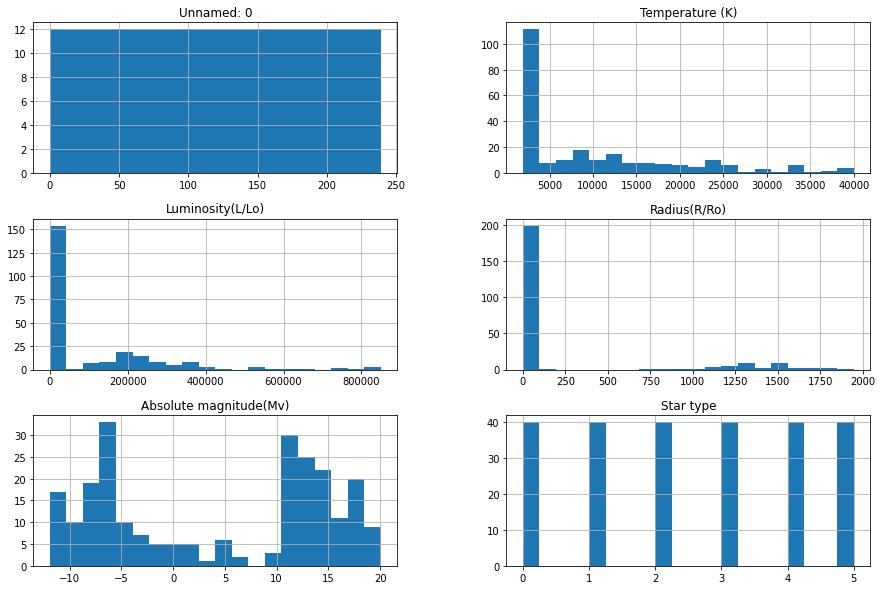

In [9]:
data.hist(bins=20, figsize=(15, 10))

## Предобработка и анализ данных

Рассмотрим подробнее каждый столбец.

'Unnamed: 0 ' повтояет индекс таблцы. При подготовке признаков его можно будет удалить.

In [10]:
data['Unnamed: 0']

0        0
1        1
2        2
3        3
4        4
      ... 
235    235
236    236
237    237
238    238
239    239
Name: Unnamed: 0, Length: 240, dtype: int64

В таблице больше данных о более "холодных" звездах.

In [11]:
data['Temperature (K)'].isna().sum()

0

In [12]:
data['Temperature (K)'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64

<AxesSubplot:>

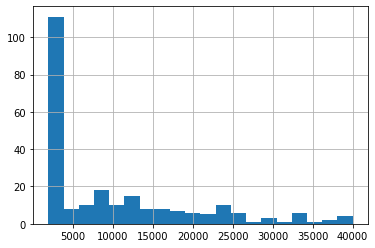

In [13]:
data['Temperature (K)'].hist(bins=20)

Предыдущий вывод относится и к светимости.

In [14]:
data['Luminosity(L/Lo)'].isna().sum()

0

In [15]:
data['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

<AxesSubplot:>

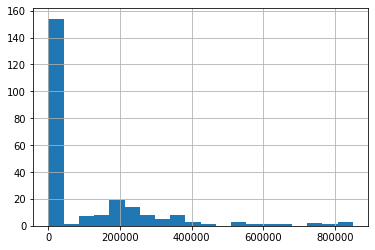

In [16]:
data['Luminosity(L/Lo)'].hist(bins=20)

Также очевидно, что в подборке немного гигантов.

In [17]:
data['Radius(R/Ro)'].isna().sum()

0

In [18]:
data['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

<AxesSubplot:>

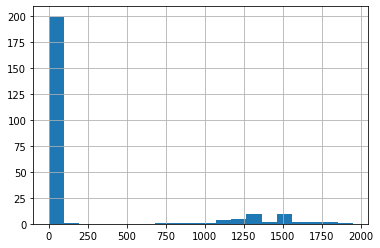

In [19]:
data['Radius(R/Ro)'].hist(bins=20)

Можно сделать похожый вывод на предыдущие про абсолютную звездную величину.

In [20]:
data['Absolute magnitude(Mv)'].isna().sum()

0

In [21]:
data['Absolute magnitude(Mv)'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

<AxesSubplot:>

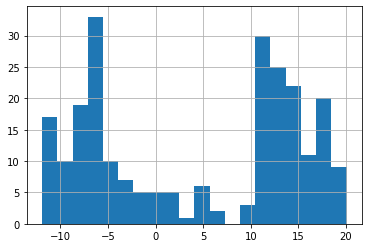

In [22]:
data['Absolute magnitude(Mv)'].hist(bins=20)

В нашем распоряжении одинаковое количество звезд каждого типа.

In [23]:
data['Star type'].isna().sum()

0

In [24]:
data['Star type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

Значения в столбце цвета звезды можно обработать - привести их к нижнему регистру и заменить дефисы на пробелы. Также мы точно не можем сказать, можно ли сделать равнозначную замену, например, yellowish white на просто white без потери смысла. Но попробуем сделать такую замену.

In [25]:
data['Star color'].isna().sum()

0

In [26]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [27]:
data['Star color'] = data['Star color'].str.lower().str.strip()

In [28]:
data['Star color'] = data['Star color'].str.replace('-', ' ')
data['Star color'] = data['Star color'].str.replace('yellowish white', 'yellow white')
data['Star color'] = data['Star color'].str.replace('white yellow', 'yellow white')
data['Star color'] = data['Star color'].str.replace('pale yellow orange', 'yellow orange')
data['Star color'] = data['Star color'].str.replace('whitish', 'white')
data['Star color'] = data['Star color'].str.replace('yellowish', 'yellow')

In [29]:
data['Star color'].value_counts()

red              112
blue              56
blue white        41
yellow white      12
white             12
yellow             3
orange             2
yellow orange      1
orange red         1
Name: Star color, dtype: int64

## Подготовка данных к построению модели

In [30]:
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,red
1,1,3042,0.000500,0.1542,16.60,0,red
2,2,2600,0.000300,0.1020,18.70,0,red
3,3,2800,0.000200,0.1600,16.65,0,red
4,4,1939,0.000138,0.1030,20.06,0,red


Для начала удалим лишний столбец

In [31]:
data = data.drop(columns=['Unnamed: 0'], axis=1)

В столбцах светимости и радиуса представлены значения относительно Солнца. Пересчитаем их в абсолютные значения.

In [32]:
L_0 = 3.828e26
R_0 = 6.9551e8

Названия цвета зведы обработаем методом get_dummies, который переведет их в формат 0, 1. 

Разделим данные на признаки и целевой признка (температура звезды). Разделим данные на обучающую и тестовую выборки в соотношении 1/4.

In [35]:
features = data.drop(columns=['Temperature (K)'], axis=1)
target = data['Temperature (K)']

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, 
                                                                            shuffle=True,
                                                                            random_state=12345)

In [37]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(192, 5)
(192,)
(48, 5)
(48,)


Приведем признаки к единому масштабу.

In [41]:
numeric = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
categorial = ['Star type', 'Star color']

In [42]:
ct = ColumnTransformer([('scaler', StandardScaler(), numeric), ('ohe', OneHotEncoder(), categorial)])

In [43]:
features_train = ct.fit_transform(features_train).toarray()
features_test = ct.transform(features_test).toarray()

## Построение базовой нейронной сети

Создадим тензоры из обучающей и тестовой выборок.

sparse matrix length is ambiguous; use getnnz() or shape[0]

In [44]:
X_train = torch.Tensor(features_train)
X_test = torch.Tensor(features_test)

In [45]:
y_train = torch.Tensor(target_train.values)
y_test = torch.Tensor(target_test.values)

Зададим количество нейронов. Рассмотрим сети с количеством скрытых слоев от 0 до 2. Количество нейронов на скрытых слоях будет определяться случайно в диапазоне 10-200. На входном и выходном слоях, соответственно, значения будут 17 и 1.

In [46]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons = list(range(10, 50))
n_hidden_neurons_1 = random.choice(n_hidden_neurons)
n_hidden_neurons_2 = random.choice(n_hidden_neurons)
n_out_neurons = 1

Инициализируем сеть.

In [47]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

Создадим классы для задания архитектуры нейросети. Они будут трех видов: без скрытого слоя, с одним скрытым слоем, с двумя скрытыми слоями. Так как мы решаем задачу регрессии, то для расчетов будем использовать линейную Linear и выпрямительную линейную ReLU функции. Для одного из скрытых слоев используем функцию гиперболического тангенса.

In [48]:
net_0 = nn.Sequential(
            nn.Linear(n_in_neurons, n_out_neurons),
            nn.ReLU()
            )

In [49]:
net_1 = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_out_neurons),
            nn.ReLU()
            )

In [50]:
net_2 = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
            )

Функция для обучения нейросети включает в себя поиск оптимального значения эпох и размера батчей.

In [51]:
def model(net):
    
    best_rmse = 50000
    best_net = None
    best_batch_size = 0
    best_epoch = 0
    
    net.apply(init_weights)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    loss = nn.MSELoss(reduction='sum')
    
    for batch_size in range(10, 31, 10):
        num_batches = ceil(len(X_train) / batch_size)
    
        for epoch in range(501):
            order = np.random.permutation(len(X_train))
            
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                
                optimizer.zero_grad()
                
                batch_indexes = order[start_index:start_index + batch_size]
                
                X_batch = X_train[batch_indexes]
                y_batch = y_train[batch_indexes]
        
                preds = net.forward(X_batch).flatten()
        
                loss_value = loss(preds, y_batch)
        
                loss_value.backward()
        
                optimizer.step()
        
            if epoch % 10 == 0:
                net.eval()
                test_preds = net.forward(X_test)
                rmse = mean_squared_error(test_preds.detach().numpy(), y_test, squared=False)
            
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_net = net
                    best_batch_size = batch_size
                    best_epoch = epoch
            
    return best_rmse, best_net, best_batch_size, best_epoch

In [52]:
%%time

best_rmse_0, best_net_0, best_batch_size_0, best_epoch_0 = model(net_0)
best_rmse_0, best_net_0, best_batch_size_0, best_epoch_0

CPU times: user 6.23 s, sys: 551 µs, total: 6.23 s
Wall time: 6.25 s


(16032.275,
 Sequential(
   (0): Linear(in_features=18, out_features=1, bias=True)
   (1): ReLU()
 ),
 30,
 500)

In [53]:
%%time

best_rmse_1, best_net_1, best_batch_size_1, best_epoch_1 = model(net_1)
best_rmse_1, best_net_1, best_batch_size_1, best_epoch_1

CPU times: user 10.1 s, sys: 3.16 ms, total: 10.1 s
Wall time: 10.1 s


(6792.836,
 Sequential(
   (0): Linear(in_features=18, out_features=34, bias=True)
   (1): ReLU()
   (2): Linear(in_features=34, out_features=1, bias=True)
   (3): ReLU()
 ),
 30,
 500)

In [54]:
%%time

best_rmse_2, best_net_2, best_batch_size_2, best_epoch_2 = model(net_2)
best_rmse_2, best_net_2, best_batch_size_2, best_epoch_2

CPU times: user 13 s, sys: 15.6 ms, total: 13 s
Wall time: 13 s


(5362.395,
 Sequential(
   (0): Linear(in_features=18, out_features=34, bias=True)
   (1): ReLU()
   (2): Linear(in_features=34, out_features=36, bias=True)
   (3): ReLU()
   (4): Linear(in_features=36, out_features=1, bias=True)
   (5): ReLU()
 ),
 30,
 480)

Наиболее близкий к целевому получился результат для сети с двумя скрытыми слоями - 4599. Построим для нее график "Факт - прогноз".

In [55]:
best_net_2.eval()
test_preds = best_net_2.forward(X_test)

In [56]:
test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['star temperature'])
y_test = pd.DataFrame(y_test, columns=['star temperature']).reset_index().drop('index', axis=1)

По графику можно сделать вывод, что сеть хорошо угадывает значения низких температур, но ошибается в предсказании высоких, что логично - в нашей выборке первых было больше.

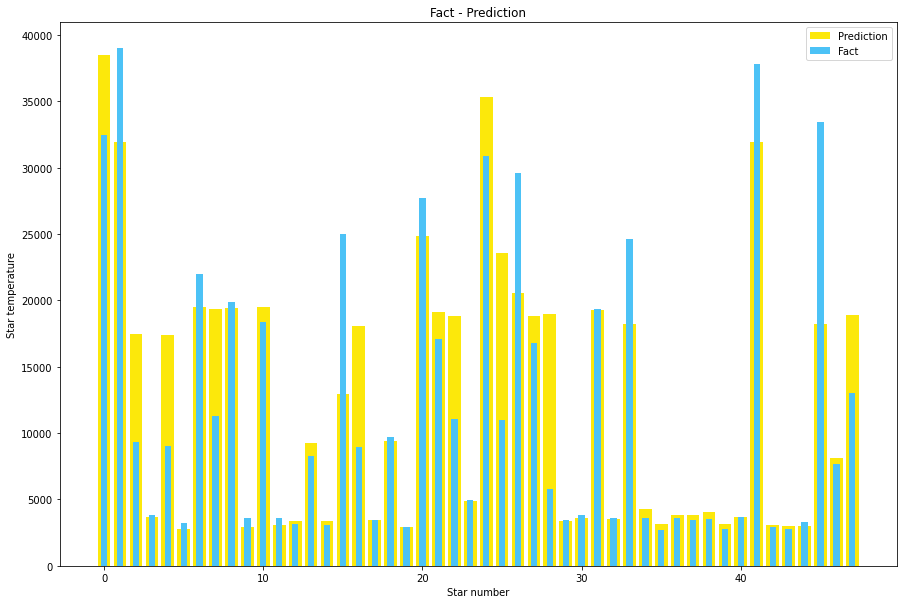

In [57]:
fig, ax = plt.subplots(figsize=[15, 10])
plt.bar(x=test_preds.index, height=test_preds['star temperature'], color='#fce80b', label='Prediction')
plt.bar(x=y_test.index, height=y_test['star temperature'], color='#4cc2f6', label='Fact', width=0.4)
plt.title('Fact - Prediction')
plt.xlabel('Star number')
plt.ylabel('Star temperature')
ax.legend()
plt.show()

## Улучшение нейронной сети

Попробуем улучшить результаты работы сети.

Ранее мы уже использовали один из инструментов для этого - поиск оптимального размера батча. Добавим еще один механизм - BatchNorm. Он борется со взрывом градиента, улучшает сходимость обучения, уменьшает зависимость от гиперпараметров и влияние инициализации весов.

По итогам можно сказать, что метод не помог улучшить результат - rmse снизилась до 4647.

In [58]:
%%time

net_1_norm = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden_neurons_1),
            nn.Linear(n_hidden_neurons_1, n_out_neurons),
            nn.ReLU()
            )

best_rmse_norm, best_net_norm, best_batch_size_norm, best_epoch_norm = model(net_1_norm)
best_rmse_norm, best_net_norm, best_batch_size_norm, best_epoch_norm

CPU times: user 1min 3s, sys: 219 ms, total: 1min 3s
Wall time: 1min 4s


(5570.7876,
 Sequential(
   (0): Linear(in_features=18, out_features=34, bias=True)
   (1): ReLU()
   (2): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Linear(in_features=34, out_features=1, bias=True)
   (4): ReLU()
 ),
 30,
 500)

In [59]:
%%time

net_2_norm = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden_neurons_1),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.BatchNorm1d(n_hidden_neurons_2),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
            )

best_rmse_norm, best_net_norm, best_batch_size_norm, best_epoch_norm = model(net_2_norm)
best_rmse_norm, best_net_norm, best_batch_size_norm, best_epoch_norm

CPU times: user 1min 28s, sys: 268 ms, total: 1min 28s
Wall time: 1min 29s


(4352.6553,
 Sequential(
   (0): Linear(in_features=18, out_features=34, bias=True)
   (1): ReLU()
   (2): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Linear(in_features=34, out_features=36, bias=True)
   (4): ReLU()
   (5): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Linear(in_features=36, out_features=1, bias=True)
   (7): ReLU()
 ),
 30,
 490)

Мы можем также выключить часть нейронов сети, использовав технику Dropout. Попробуем варианты, при которых на каждом скрытом слое будут "выключаться" 25%, 50%, 75% нейронов.

In [64]:
%%time

dropout = [0.25, 0.5, 0.75]

for i in dropout:
    for j in dropout:
        net_2_drop = nn.Sequential(
            nn.Linear(n_in_neurons, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Dropout(p=i),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Dropout(p=j),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.ReLU()
            )
        print(i, j)
        best_rmse_drop, best_net_drop, best_batch_size_drop, best_epoch_drop = model(net_2_drop)
        print(best_rmse_drop)

0.25 0.25
5368.0015
0.25 0.5
5373.101
0.25 0.75
5377.4136
0.5 0.25
5396.144
0.5 0.5
5384.9233
0.5 0.75
5409.7744
0.75 0.25
5388.84
0.75 0.5
5384.366
0.75 0.75
5381.397
CPU times: user 2min 8s, sys: 51.6 ms, total: 2min 8s
Wall time: 2min 8s


In [233]:
net_2_norm.eval()
test_preds = net_2_norm.forward(X_test)

In [234]:
test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['star temperature'])
y_test = pd.DataFrame(y_test, columns=['star temperature']).reset_index().drop('index', axis=1)

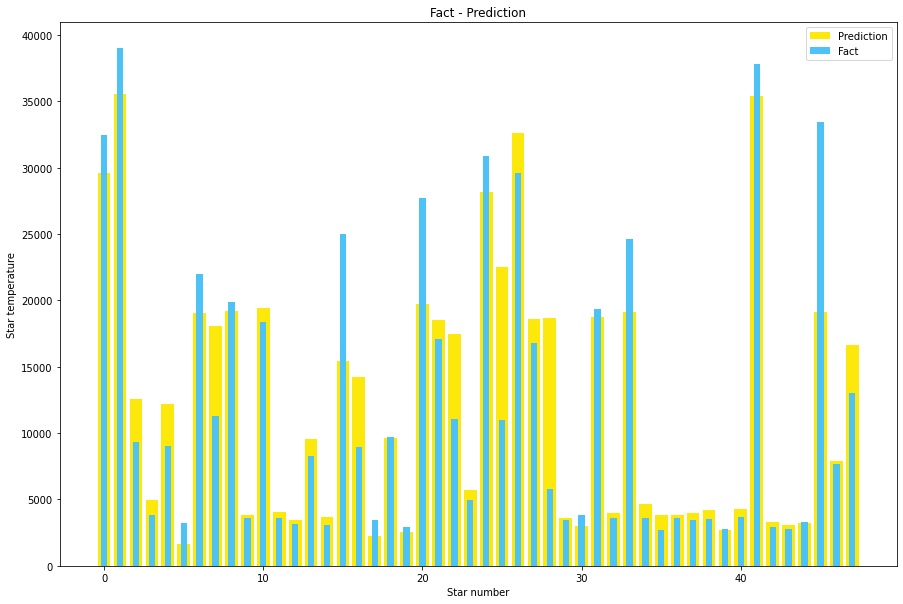

In [235]:
fig, ax = plt.subplots(figsize=[15, 10])
plt.bar(x=test_preds.index, height=test_preds['star temperature'], color='#fce80b', label='Prediction')
plt.bar(x=y_test.index, height=y_test['star temperature'], color='#4cc2f6', label='Fact', width=0.4)
plt.title('Fact - Prediction')
plt.xlabel('Star number')
plt.ylabel('Star temperature')
ax.legend()
plt.show()

## Вывод

In [237]:
rmse_list = []

In [238]:
net_2_norm.apply(init_weights)
    
optimizer = torch.optim.Adam(net_2_norm.parameters(), lr=1.0e-3)
    
loss = nn.MSELoss(reduction='sum')
    
for batch_size in range(10, 31, 10):
    num_batches = ceil(len(X_train) / batch_size)
    
    for epoch in range(501):
        order = np.random.permutation(len(X_train))
            
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
                
            optimizer.zero_grad()
                
            batch_indexes = order[start_index:start_index + batch_size]
                
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = net_2_norm.forward(X_batch).flatten()
        
            loss_value = loss(preds, y_batch)
        
            loss_value.backward()
        
            optimizer.step()
        
        if epoch % 10 == 0:
            net_2_norm.eval()
            test_preds = net_2_norm.forward(X_test)
            rmse = mean_squared_error(test_preds.detach().numpy(), y_test, squared=False)
            rmse_list.append(rmse)

In [239]:
len(rmse_list)

153

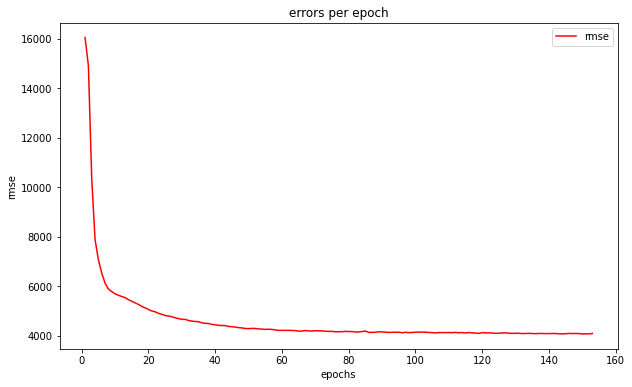

In [240]:
epochs = np.arange(1, 154)
plt.figure(figsize=[10,6])
sns.lineplot(x=epochs, y=rmse_list, label='rmse', color='red')
plt.legend()
plt.title('errors per epoch')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()

Нашей задачей в проекте было придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Для этого в нашем распоряжении имелись характеристики по уже изученным 240 звездам. Они включают в себя данные об относительной светимости, относительном радиусе, абсолютной звездной величине, звездном цвете, типе звезды, абсолютной температуре (целевой признак).

Мы провели предобработку данных и их подготовку к построению модели. Были обработаны количественные и качественные признаки. Данные разделены на обучающую и тестовую выборки.

С помощью контейнера Sequential была задана архитектура нейронной сети. Для построения модели мы использовали сети с числом скрытых слоев от 0 до 2. В скрытых слоях число нейронов определялось случайным образом в диапазоне 10-200. В качестве функции активации использованы ReLU и Linear, так как мы решаем задачу регрессии. На первом скрытом слое была использована функция гиперболического тангенса.

Перебором размера батчей и количества эпох обучения на сети с двумя скрытыми слоями удалось достичь максимального показателя RMSE в 4599.

Мы попытались улучшить этот результат нормализацией батчей и «выключением» части нейронов, но превзойти его не удалось. 

В целом модель хорошо угадывает температуру «холодных» звезд, так как информации о них больше в предоставленных данных, и промахивается с определением температуры у более горячих.

Графики зависимости RMSE от количества эпох дает представление о том, как обучалась и какой результат выдавала наша модель.
